In [1]:
import pandas as pd
import os
import json
import csv
import collections
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.backends.backend_pdf import PdfPages
import statistics

# import numpy as np
# from numpy.polynomial.polynomial import polyfit


In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [3]:
# ielasām 4 failus priekš vizualizācijas
all_words_and_contexts = pd.read_csv('_54_PRECIZETS_kermena_vardi_vardskira_konteksts_17835_attiriti.csv', index_col=[0])
kv_lemmas_counts = pd.read_csv('_55_PRECIZETS_atslegvardi_lemmas_count.csv')   # with index_col=[0] there was unneeded multi-level index
kv_types_absolute = pd.read_csv('_56_PRECIZETS_kermena_vardi_absolute_counts.csv', index_col=[0])
kv_types_relative = pd.read_csv('_57_PRECIZETS_kermena_vardi_RELATIVE_counts.csv', index_col=[0])

kv_sorted_for_viz = pd.read_csv('_61_kermena_vardi_sorted_for_visualization', index_col=[0])


In [4]:
kv_sorted_for_viz.head()

,lemma,rank,faila_nosaukums,tokens_count
14548,roka,0.0,1893MedinskaMarijaSērdienīteStasts,7148
14549,roka,0.0,1893MedinskaMarijaSērdienīteStasts,7148
14550,roka,0.0,1893MedinskaMarijaSērdienīteStasts,7148
14551,roka,0.0,1893MedinskaMarijaSērdienīteStasts,7148
14552,roka,0.0,1893MedinskaMarijaSērdienīteStasts,7148


In [5]:
# df, kur ir visu tekstu tokens_count
tokens_in_files = kv_types_relative[['faila_nosaukums', 'tokens_count']].copy()
# tokens_in_files

filenames_list = tokens_in_files['faila_nosaukums'].tolist()
filenames_list = sorted(filenames_list)
filenames_list[:5]

['1893MedinskaMarijaSērdienīteStasts',
 '1894AspazijaCinaParNakamibuNovele',
 '1895ZaliteHermineEjUnIzglitojiesStasts',
 '1896ZaliteHermineIzlīdzētsStasts',
 '1896ZaliteHermineMūsuCeliSkirasStasts']

In [6]:
kv_types_relative.head()

,faila_nosaukums,VISS_KERMENIS,KERMENA_DALAS,GALVA_UN_DALAS,CITI_VARDI,TOTAL,tokens_count,kv_procentos
29,1905ZemgaliesuBirutaJurmalasBernsSkice,0.4125,0.6601,2.6403,0.4125,50,1212,4.13
251,1994ZemdegaAinaAtgriesanasStasts,0.1399,1.7716,1.6783,0.3263,84,2145,3.92
119,1930BangaTijaAktriseSkice,0.3317,0.9950,2.3217,0.1658,23,603,3.81
255,1998AbeleIngaNatresSkice,0.0990,1.5842,1.6832,0.3960,38,1010,3.76
46,1911LicisuPaulaDivasRokasSkice,0.0000,2.8476,0.6700,0.1675,22,597,3.69


In [7]:
lemmas_list = kv_lemmas_counts["lemma"].tolist()
lemmas_list[:10]

['roka',
 'acs',
 'galva',
 'seja',
 'kāja',
 'mats',
 'plecs',
 'lūpa',
 'pirksts',
 'mute']

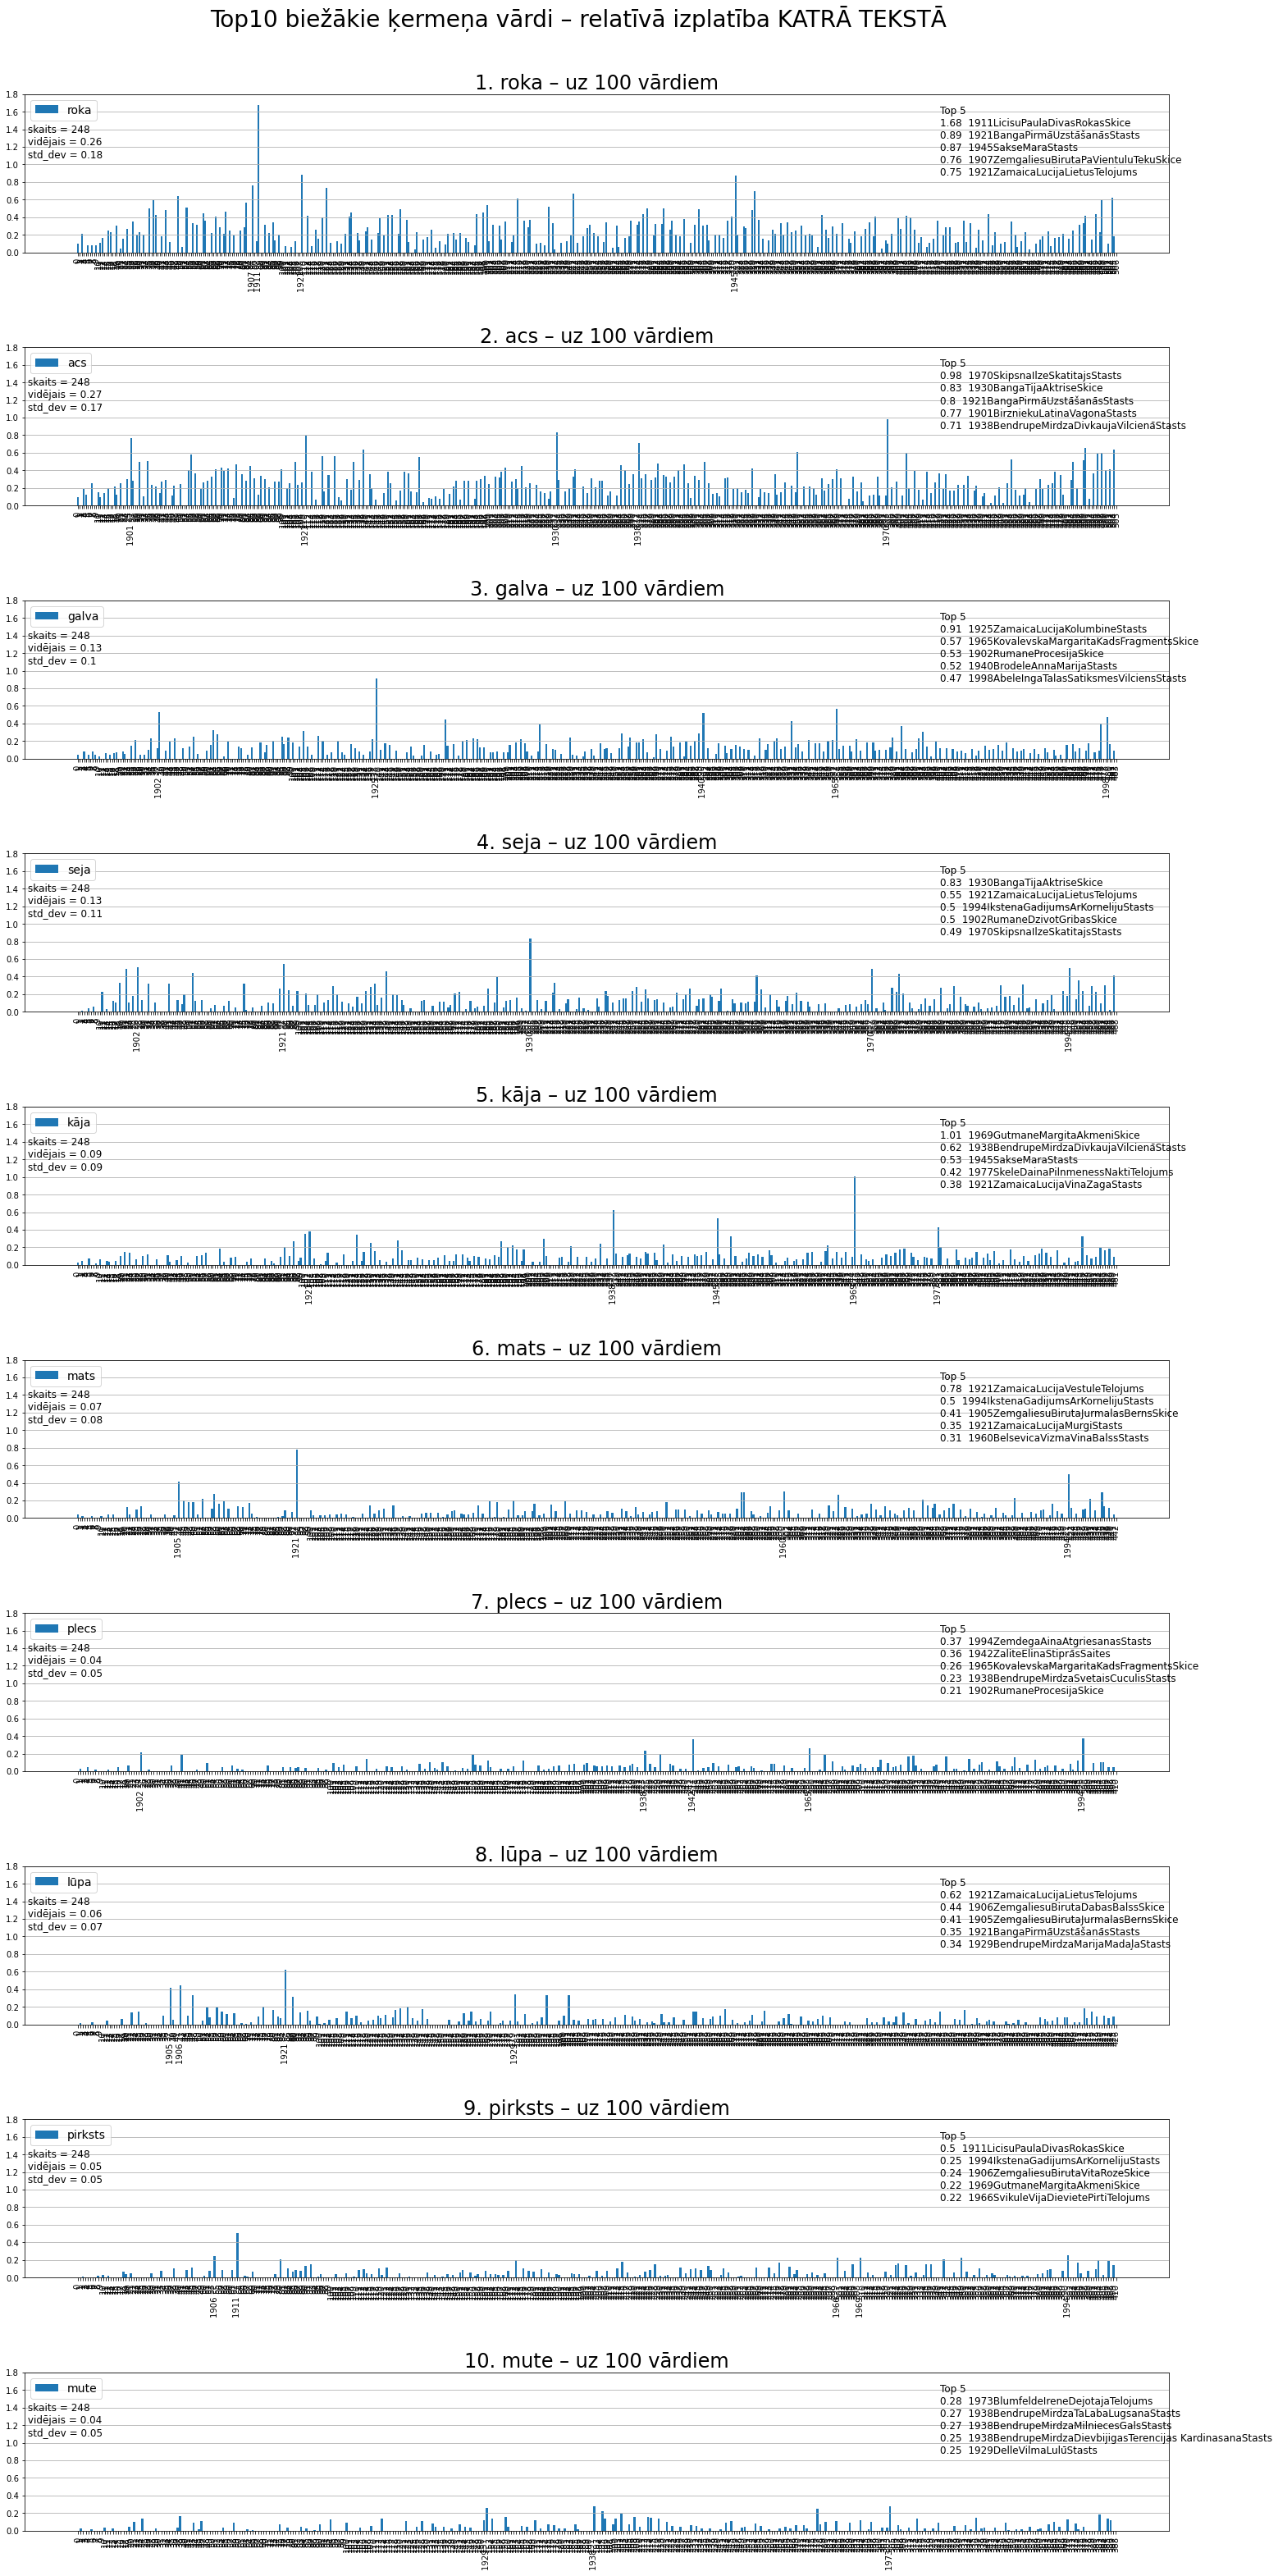

In [8]:
lemmas_list = kv_lemmas_counts["lemma"].tolist()
# print(lemmas_list[:10])

# Subplots are organized in a Rows x Cols Grid  # Tot and Cols are known
Tot = 10
Cols = 1
Rows = Tot // Cols   # Compute num of full Rows required
Rows += Tot % Cols   # Add remainder to Rows num

# Create a Position index
Position = range(1,Tot + 1)

# Create main figure
f = plt.figure(figsize=(25, 50))

top5_aggregate = []

for k, lemma in enumerate(lemmas_list[:10]):
    temp_df = kv_sorted_for_viz.loc[kv_sorted_for_viz["lemma"] == lemma]
    # getting pandas Series and setting column_name "counts" to the new column
    counts = temp_df.value_counts().reset_index(name="counts")
    counts_df = pd.DataFrame(counts) # converting pandas Series to Dataframe
    for fname in filenames_list:
        if fname not in counts_df['faila_nosaukums']:
            counts_df = counts_df.append({
                                        'counts':0,
                                        'faila_nosaukums':fname, 
                                        "lemma": lemma,
                                        "rank": "not_calculated",
                                        "tokens_count": 1
                                        }, ignore_index=True)
            check_df = counts_df.copy()

    counts_df = counts_df.sort_values('faila_nosaukums')
    counts_df["relative"] = (counts_df["counts"]/counts_df["tokens_count"]) * 100
    
    # calculation for y_values
    relatives_list = list(counts_df['relative'])
    sorted_y = sorted(relatives_list, reverse=True)
    fifth_value = sorted_y[4]

    # calculation for x_values
    fnames_list = list(counts_df['faila_nosaukums'])
    new_x_list = []
    text_box = []
    for idx, (x_val, y_val) in enumerate(zip(fnames_list, relatives_list)):
        if y_val < fifth_value:
            new_x_list.append(str(idx))
        else:
            new_x_list.append(x_val[:4] + "     ")
            text_box.append([ round(y_val, 2), x_val])
            top5_aggregate.append(x_val)

    text_box = sorted(text_box, reverse=True)
    text_box = [ f"{el[0]}  {el[1]}" for el in text_box]
    text_box.insert(0, "Top 5")
    text_string = "\n".join(text_box)
    
    x = new_x_list
    y = relatives_list
    label = lemma
    
    skaits = 248
    average = sum(counts_df["relative"].tolist()) / 248
    average =  round(average, 2)
    std_dev = statistics.stdev(y)
    std_dev = round(std_dev, 2)
#     linelength = temp_df.shape[0]
    num_avg_std_dev = f" skaits = {skaits} \n vidējais = {average} \n std_dev = {std_dev}"
    
    # add every single subplot to the figure with a for loop
    ax1 = f.add_subplot(Rows,Cols,Position[k])

    ax1.grid(axis='y')
    ax1.bar(x,y, label=label)
#     ax1.set_ylabel('lietojumu skaits uz 100 vārdiem', fontsize=18)
    ax1.set_title(f'{k+1}. {lemma} – uz 100 vārdiem', fontsize=24)
    ax1.legend([lemma], fontsize=14, loc='upper left')
    ax1.text(0.8, 0.7, text_string, fontsize=12, horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes)
    ax1.text(0.0, 0.7, num_avg_std_dev, fontsize=12, horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes)
    ax1.set_ylim(0, 1.8)
    plt.xticks(rotation=90)

f.suptitle('Top10 biežākie ķermeņa vārdi – relatīvā izplatība KATRĀ TEKSTĀ', fontsize=28)
f.subplots_adjust(hspace=0.6)
f.subplots_adjust(top=0.95)

# from matplotlib import pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages
### IZKOMENTĒTS, lai nenotiek pārrakstīšana pa virsu failam
# pp = PdfPages('_71_top10_kermena_vardi_pa_tekstiem_PRECIZETS.pdf')
# plt.savefig(pp, format='pdf')
# pp.close()

plt.show()

# Top10 biežākie ķermeņa vārdi – relatīvā izplatība KATRĀ TEKSTĀ
Top5 no katra teksta parāda, ka biežāka ķermeņa vārdu izplatība nav saistīta ar konkrētu laikmetu, bet ir atkarīga no atsevišķā teksta. 

**Vidējās vērtības** – Skatoties uz vidējām vērtībām ("vidējais") un standarta novirzi ("std_dev"), redzams, ka ir ļoti plaša dažādība – ir daži teksti ar ļoti augstu ķermeņa vārdu izplatību, kas paceļ vidējo vērtību, taču lielā standarta novirze parāda, ka vidējā vērtība nav diez cik raksturojoša korpusam kopumā. Iespējams, ka lietderīga pieeja būtu pievērsties max (un arī min) tekstiem kvalitatīvas analīzes veidā – pētot, vai šie teksti ir kvalitatīvi atšķirīgi no citiem un vai ķermeņa vārdu intensitāte iezīmē atšķirīgu diskursību attieksmi pret ķermeni, vai arī tā ir vien autores stilistikas īpatnība.

**Teksti iekš Top5** – Ja saskaita tekstus, kas parādās Top5 katram no 10 biežākajiem vārdiem, tad kopumā parādās 35 unikāli teksti, no kuriem 3 teksti ir pieminēti trīs reizes, 9 teksti divas reizes, un 23 teksti vienu reizi:

('1921BangaPirmāUzstāšanāsStasts', 3), <br>
('1921ZamaicaLucijaLietusTelojums', 3), <br>
('1994IkstenaGadijumsArKornelijuStasts', 3),<br>
('1911LicisuPaulaDivasRokasSkice', 2), <br>
('1945SakseMaraStasts', 2), <br>
('1930BangaTijaAktriseSkice', 2), <br>
('1938BendrupeMirdzaDivkaujaVilcienāStasts', 2), <br>
('1970SkipsnaIlzeSkatitajsStasts', 2), <br>
('1902RumaneProcesijaSkice', 2), <br>
('1965KovalevskaMargaritaKadsFragmentsSkice', 2), <br>
('1969GutmaneMargitaAkmeniSkice', 2), <br>
('1905ZemgaliesuBirutaJurmalasBernsSkice', 2), <br>

Tas varētu ļaut izdarīt pieņēmumu, ka pie lielas ķermeņa vārdu intensitātes uzmanība tiek pievērsta atsevišķiem vārdiem vai ķermeņa apgabaliem, bet ne VISIEM ķermeņa vārdiem vairāk. Iespējams, šeit noderētu biežāko tekstu tuvlasījums, lai noteiktu vai statistikās tendences uzrāda diskursīvu praksi attiecībā uz ķermeni, vai ir vien ornamentāli elementi.

Raugoties uz šo 12 tekstu nosaukumiem, kas atkārtojas vairākas reizes, redzams, ka tikai "Banga" ir pārstāvēta šajā sarakstā ar diviem dažādiem stāstiem.

**Biežāk pārstāvētās autores** – Sagrupējot visus 35 tekstus (arī tos, kas vienreiz tikai parādās), biežāk iekļuvušās autores ir: Bendrupe 6, Zamaiča 5, Zemgaliešu Biruta 4, Banga 2, Rumane 2:

'1929BendrupeMirdzaMarijaMadaļaStasts': 1, <br>
'1938BendrupeMirdzaDivkaujaVilcienāStasts': 2, <br>
'1938BendrupeMirdzaDievbijigasTerencijas KardinasanaStasts': 1, <br>
'1938BendrupeMirdzaMilniecesGalsStasts': 1, <br>
'1938BendrupeMirdzaTaLabaLugsanaStasts': 1, <br>
'1938BendrupeMirdzaSvetaisCuculisStasts': 1, <br>

'1921ZamaicaLucijaLietusTelojums': 3, <br>
'1921ZamaicaLucijaVinaZagaStasts': 1,<br>
'1921ZamaicaLucijaMurgiStasts': 1, <br>
'1921ZamaicaLucijaVestuleTelojums': 1, <br>
'1925ZamaicaLucijaKolumbineStasts': 1, <br>

'1905ZemgaliesuBirutaJurmalasBernsSkice': 2, <br>
'1906ZemgaliesuBirutaVitaRozeSkice': 1, <br>
'1906ZemgaliesuBirutaDabasBalssSkice': 1, <br>
'1907ZemgaliesuBirutaPaVientuluTekuSkice': 1, <br>

'1921BangaPirmāUzstāšanāsStasts': 3, <br>
'1930BangaTijaAktriseSkice': 2, <br>

'1902RumaneProcesijaSkice': 2, <br>
'1902RumaneDzivotGribasSkice': 1, <br>

'1994IkstenaGadijumsArKornelijuStasts': 3, <br>
'1945SakseMaraStasts': 2, <br>
'1911LicisuPaulaDivasRokasSkice': 2, <br>
'1970SkipsnaIlzeSkatitajsStasts': 2, <br>
'1965KovalevskaMargaritaKadsFragmentsSkice': 2, <br>
'1969GutmaneMargitaAkmeniSkice': 2, <br>
'1901BirzniekuLatinaVagonaStasts': 1, <br>
'1940BrodeleAnnaMarijaStasts': 1, <br>
'1998AbeleIngaTalasSatiksmesVilciensStasts': 1, <br>
'1977SkeleDainaPilnmenessNaktiTelojums': 1, <br>
'1960BelsevicaVizmaVinaBalssStasts': 1, <br>
'1942ZaliteElinaStiprāsSaites': 1, <br>
'1994ZemdegaAinaAtgriesanasStasts': 1, <br>
'1966SvikuleVijaDievietePirtiTelojums': 1, <br>
'1929DelleVilmaLulūStasts': 1, <br>
'1973BlumfeldeIreneDejotajaTelojums': 1 <br>

Kādi no tā būtu izdarāmi secinājumi, ir rūpīgāk pētāms jautājums. Jo Bendrupe, Zamaiča, Zemgaliešu Biruta, Banga, Rumane ir autores, kuras korpusā pārstāvētas ar vislielāko darbu īpatsvaru, līdz ar to viņu biežāka pārādīšanās varētu būt skaidrojama ar lielāku daudzumu izlases kopumā.

In [9]:
# top5_aggregate
# counter = collections.Counter(top5_aggregate)

# counter.most_common(15)

In [10]:
decades = [
    1899, 1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2002
]

decades_mapping = {
#     0: "līdz 1892",
    0: "1893 – 1899",
    1: "1900 – 1909",
    2: "1910 – 1919",
    3: "1920 – 1929",
    4: "1930 – 1939",
    5: "1940 – 1949",
    6: "1950 – 1959",
    7: "1960 – 1969",
    8: "1970 – 1979",
    9: "1980 – 1989",
    10: "1990 – 2002"
}


In [11]:
def check_if_bigger(file_name, times_list, mapping):
    num = 0
    for val in times_list:
        if int(file_name[:4]) > val:
            num += 1
    return(mapping[num])

# check_if_bigger("1894AspazijaCinaParNakamibuNovele", decades)

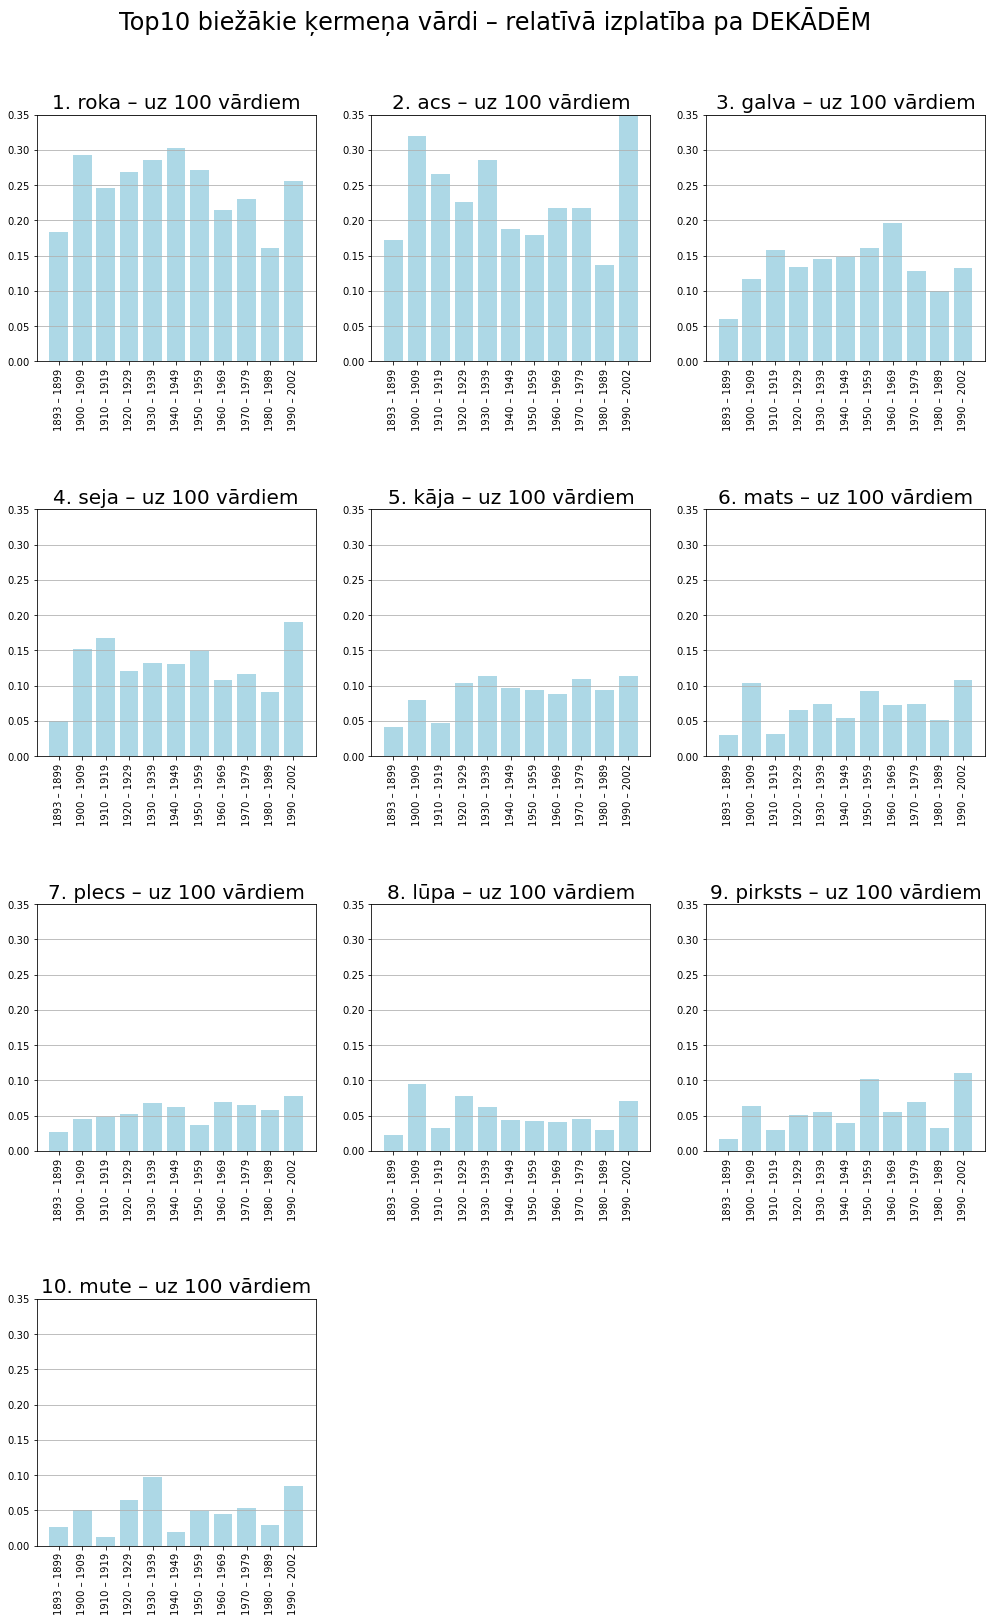

In [12]:
lemmas_list = kv_lemmas_counts["lemma"].tolist()

# Subplots are organized in a Rows x Cols Grid  # Tot and Cols are known
Tot = 10
Cols = 3
Rows = Tot // Cols   # Compute num of full Rows required
Rows += Tot % Cols   # Add remainder to Rows num

# Create a Position index
Position = range(1,Tot + 1)

# Create main figure
f = plt.figure(figsize=(17, 25))

for k, lemma in enumerate(lemmas_list[:10]):
    temp_df = kv_sorted_for_viz.loc[kv_sorted_for_viz["lemma"] == lemma]
    # getting pandas Series and setting column_name "counts" to the new column
    counts = temp_df.value_counts().reset_index(name="counts")
    counts_df = pd.DataFrame(counts) # converting pandas Series to Dataframe
    for fname in filenames_list:
        if fname not in counts_df['faila_nosaukums']:
            counts_df = counts_df.append({
                                        'counts':0,
                                        'faila_nosaukums':fname, 
                                        "lemma": lemma,
                                        "rank": "not_calculated",
                                        "tokens_count": 1
                                        }, ignore_index=True)
    check_df = counts_df.copy()
    
    counts_df = counts_df.sort_values('faila_nosaukums')
    counts_df["relative"] = (counts_df["counts"]/counts_df["tokens_count"]) * 100
    #     print(counts_df)
    
    for ind, row in counts_df.iterrows():
        counts_df.loc[ind, "time_group"] = check_if_bigger(row["faila_nosaukums"], decades, decades_mapping)    
    #     print(counts_df['faila_nosaukums'], counts_df["time_group"])
    counts_df = counts_df[["lemma", "rank", "tokens_count", "counts", "time_group"]]
    counts_df["num_of_texts"] = 1
    
    aggregation_functions = {'tokens_count': 'sum', 'counts': 'sum', "num_of_texts": "sum", 'lemma': 'first'}
    counts_df_new = counts_df.groupby(['time_group', 'lemma', 'rank'], as_index=False).aggregate(aggregation_functions).reindex(columns=counts_df.columns)
    counts_df_new["relative_count"] = (counts_df_new["counts"]  / counts_df_new["tokens_count"]) * 100
    #     counts_df_new

    x = counts_df_new["time_group"].tolist()
    y = counts_df_new["relative_count"].tolist()
    text_counts = counts_df_new["num_of_texts"].tolist()
#     label = lemma
    
    ax1 = f.add_subplot(Rows,Cols,Position[k])  # add every single subplot to the figure with a for loop

    ax1.grid(axis='y')
    bars = ax1.bar(x,y, label=label, color="#add8e6")     # assign your bars to a variable
#     for idx, bar in enumerate(bars):
#         ax1.text(bar.get_x() + 0.2, 0.009, text_counts[idx], color="grey")
    
    ax1.set_title(f'{k+1}. {lemma} – uz 100 vārdiem', fontsize=20)
    ax1.set_ylim(0, 0.35)
    plt.xticks(rotation=90)
#     plt.set_title(f'lielais virsraksts', fontsize=24)

f.suptitle('Top10 biežākie ķermeņa vārdi – relatīvā izplatība pa DEKĀDĒM', fontsize=24)
f.subplots_adjust(hspace=0.6)
f.subplots_adjust(top=0.92)

### IZKOMENTĒTS, lai nenotiek pārrakstīšana pa virsu failam
# pp = PdfPages('_72_top10_kermena_vardi_pa_dekadem_PRECIZETS.pdf')
# plt.savefig(pp, format='pdf')
# pp.close()

plt.show()

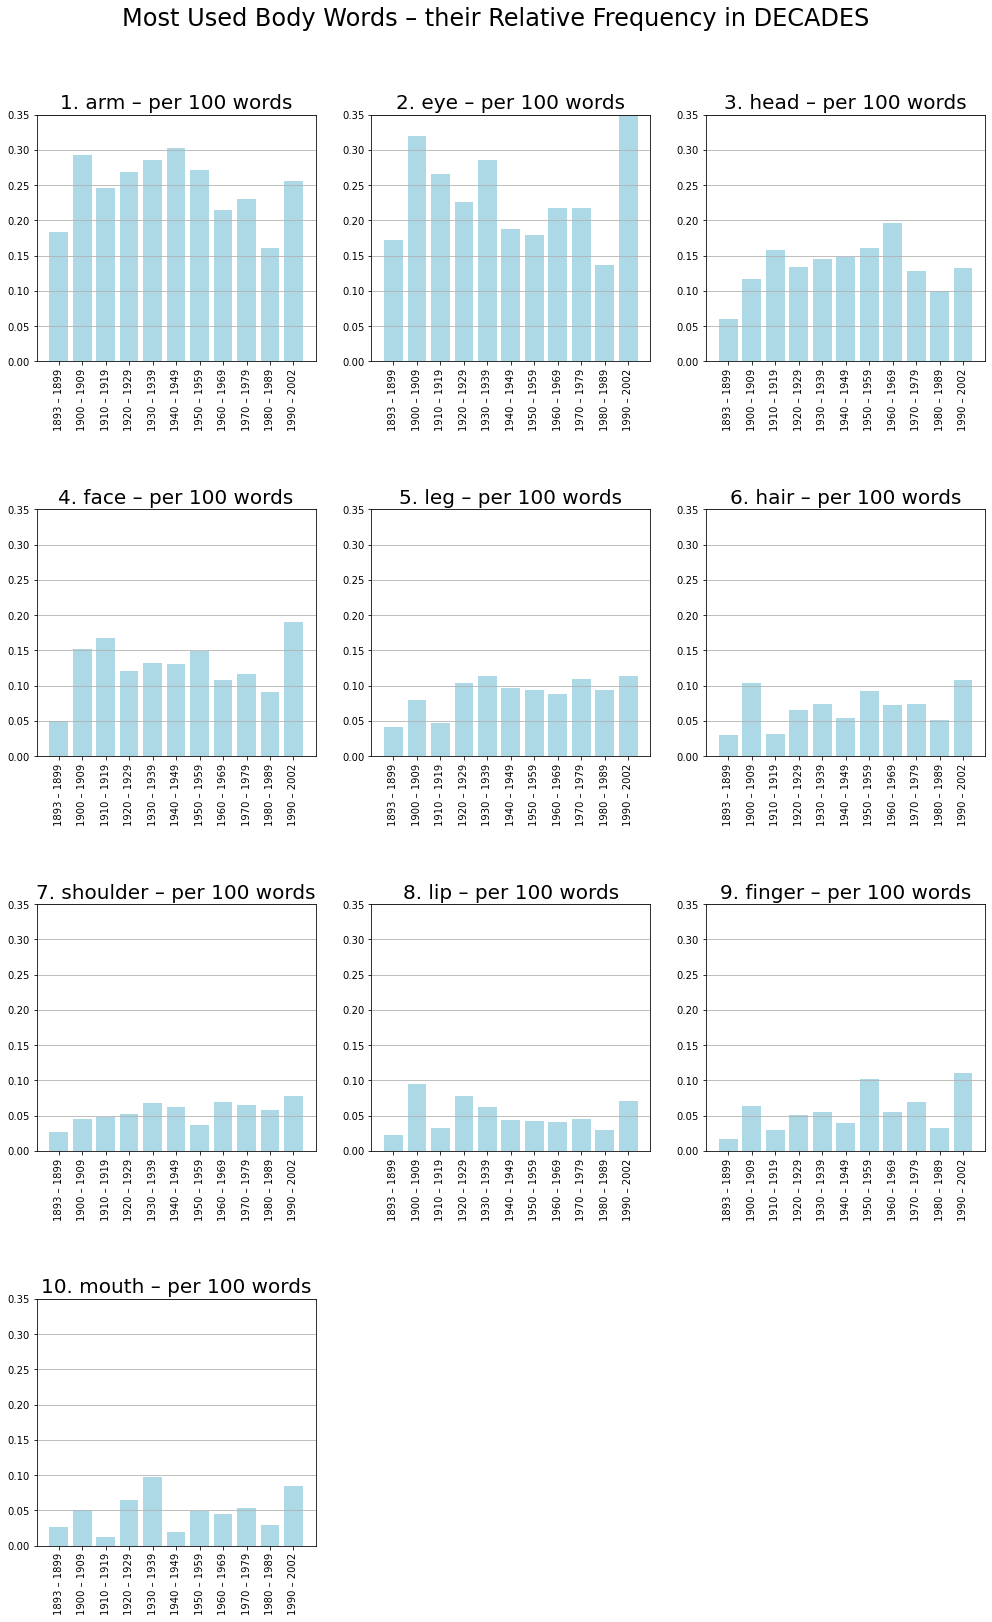

In [25]:
### the same plot as in previous – in ENGLISH

lat_to_eng = {
"roka": "arm",
"acs": "eye",
"galva": "head",
"seja": "face",
"kāja": "leg",
"mats": "hair",
"plecs": "shoulder",
"lūpa": "lip",
"pirksts": "finger",
"mute": "mouth"
}


lemmas_list = kv_lemmas_counts["lemma"].tolist()

# Subplots are organized in a Rows x Cols Grid  # Tot and Cols are known
Tot = 10
Cols = 3
Rows = Tot // Cols   # Compute num of full Rows required
Rows += Tot % Cols   # Add remainder to Rows num

# Create a Position index
Position = range(1,Tot + 1)

# Create main figure
f = plt.figure(figsize=(17, 25))

for k, lemma in enumerate(lemmas_list[:10]):
    temp_df = kv_sorted_for_viz.loc[kv_sorted_for_viz["lemma"] == lemma]
    # getting pandas Series and setting column_name "counts" to the new column
    counts = temp_df.value_counts().reset_index(name="counts")
    counts_df = pd.DataFrame(counts) # converting pandas Series to Dataframe
    for fname in filenames_list:
        if fname not in counts_df['faila_nosaukums']:
            counts_df = counts_df.append({
                                        'counts':0,
                                        'faila_nosaukums':fname, 
                                        "lemma": lemma,
                                        "rank": "not_calculated",
                                        "tokens_count": 1
                                        }, ignore_index=True)
    check_df = counts_df.copy()
    
    counts_df = counts_df.sort_values('faila_nosaukums')
    counts_df["relative"] = (counts_df["counts"]/counts_df["tokens_count"]) * 100
    #     print(counts_df)
    
    for ind, row in counts_df.iterrows():
        counts_df.loc[ind, "time_group"] = check_if_bigger(row["faila_nosaukums"], decades, decades_mapping)    
    #     print(counts_df['faila_nosaukums'], counts_df["time_group"])
    counts_df = counts_df[["lemma", "rank", "tokens_count", "counts", "time_group"]]
    counts_df["num_of_texts"] = 1
    
    aggregation_functions = {'tokens_count': 'sum', 'counts': 'sum', "num_of_texts": "sum", 'lemma': 'first'}
    counts_df_new = counts_df.groupby(['time_group', 'lemma', 'rank'], as_index=False).aggregate(aggregation_functions).reindex(columns=counts_df.columns)
    counts_df_new["relative_count"] = (counts_df_new["counts"]  / counts_df_new["tokens_count"]) * 100
    #     counts_df_new

    x = counts_df_new["time_group"].tolist()
    y = counts_df_new["relative_count"].tolist()
    text_counts = counts_df_new["num_of_texts"].tolist()
#     label = lemma
    
    ax1 = f.add_subplot(Rows,Cols,Position[k])  # add every single subplot to the figure with a for loop

    ax1.grid(axis='y')
    bars = ax1.bar(x,y, label=label, color="#add8e6")     # assign your bars to a variable
#     for idx, bar in enumerate(bars):
#         ax1.text(bar.get_x() + 0.2, 0.009, text_counts[idx], color="grey")
    
    ax1.set_title(f'{k+1}. {lat_to_eng[lemma]} – per 100 words', fontsize=20)
    ax1.set_ylim(0, 0.35)
    plt.xticks(rotation=90)
#     plt.set_title(f'lielais virsraksts', fontsize=24)

f.suptitle('Most Used Body Words – their Relative Frequency in DECADES', fontsize=24)
f.subplots_adjust(hspace=0.6)
f.subplots_adjust(top=0.92)

### IZKOMENTĒTS, lai nenotiek pārrakstīšana pa virsu failam
# pp = PdfPages('_72_top10_kermena_vardi_pa_dekadem_PRECIZETS.pdf')
# plt.savefig(pp, format='pdf')
# pp.close()

plt.show()

# Datu analīze – Top10 vārdi pa DEKĀDĒM
Redzamas 2 tendences, kas kopīgas visiem 10 grafikiem:
(1) ķermeņa vārdu pieaugums starp 1. dekādi (1893 – 1899) un 2. dekādi (1900 – 1909)
(2) ķermeņa vārdu pieaugums starp 10. dekādi (1980 – 1989) un 11. dekādi (1990 – 2002)
Īpaši vārdiem – roka, acs, seja, mats, lūpa, pirksts, mute.
Tekstu skaits katrā no šīm dekādēm gan ir salīdzinoši tik neliels, ka statistiski nozīmīgus secinājumus 
no tā izdarīt nevar.




In [13]:
hist_periods = [
    1917,
    1939,
    1989,
    2002
]

hist_per_mappings = {
    0: "1893 – 1917",
    1: "1918 – 1939",
    2: "1940 – 1989",
    3: "1990 – 2002",
}


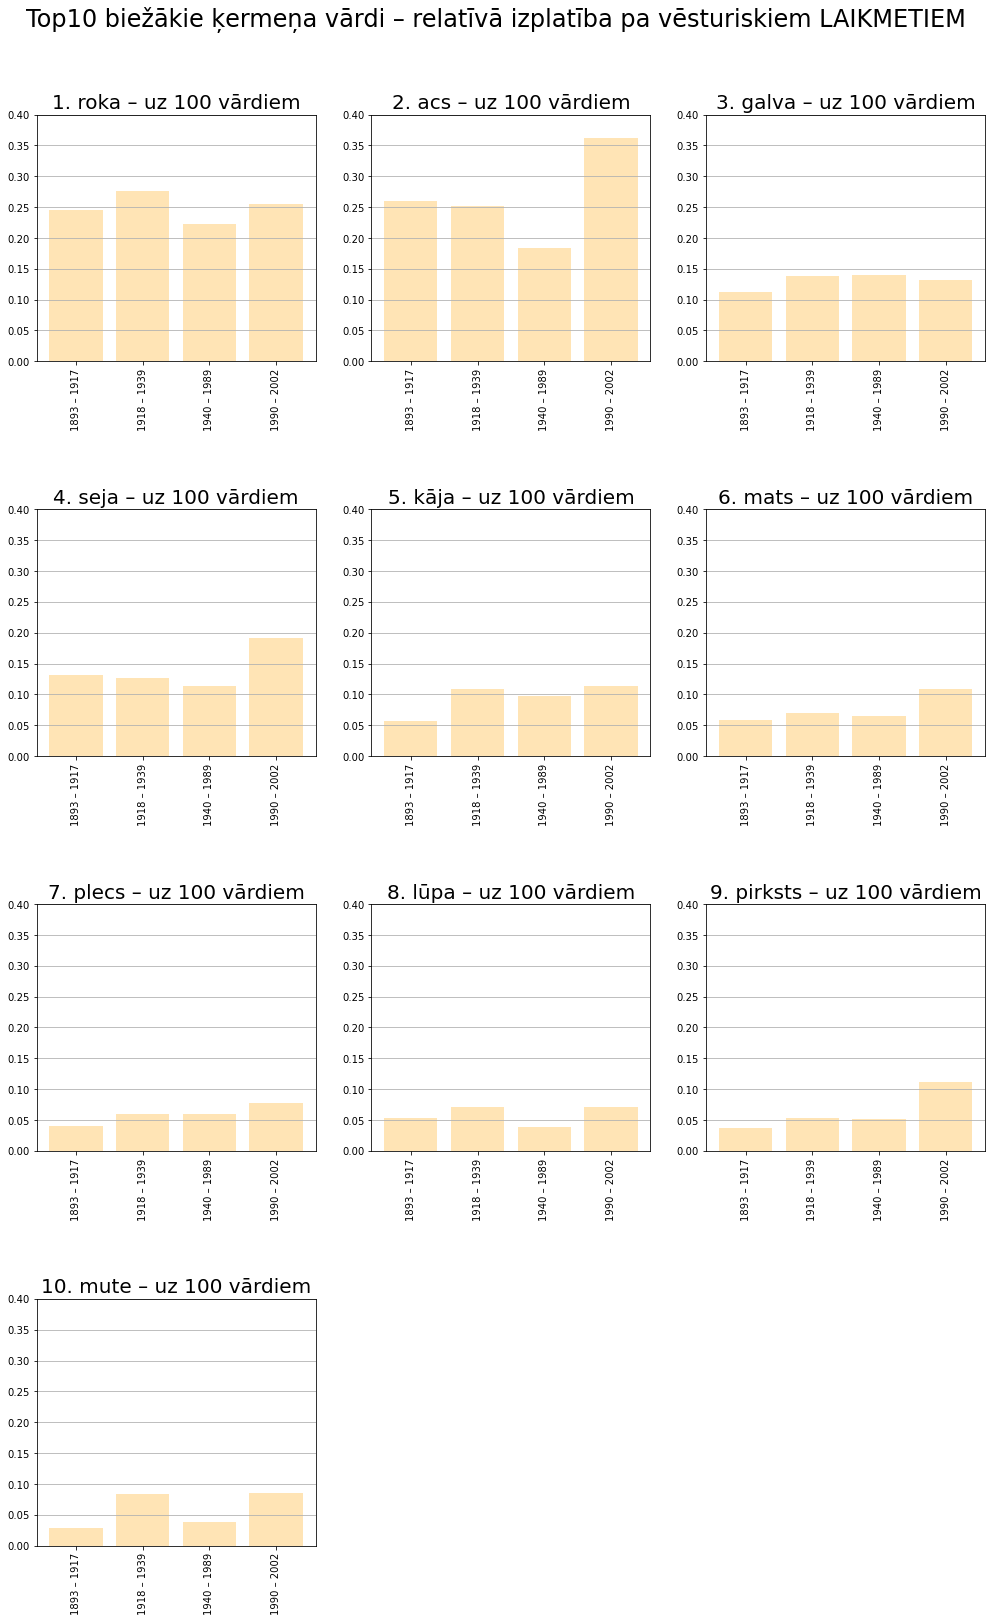

In [14]:
lemmas_list = kv_lemmas_counts["lemma"].tolist()

# Subplots are organized in a Rows x Cols Grid  # Tot and Cols are known
Tot = 10
Cols = 3
Rows = Tot // Cols   # Compute num of full Rows required
Rows += Tot % Cols   # Add remainder to Rows num

# Create a Position index
Position = range(1,Tot + 1)

# Create main figure
f = plt.figure(figsize=(17, 25))

for k, lemma in enumerate(lemmas_list[:10]):
    temp_df = kv_sorted_for_viz.loc[kv_sorted_for_viz["lemma"] == lemma]
    # getting pandas Series and setting column_name "counts" to the new column
    counts = temp_df.value_counts().reset_index(name="counts")
    counts_df = pd.DataFrame(counts) # converting pandas Series to Dataframe
    for fname in filenames_list:
        if fname not in counts_df['faila_nosaukums']:
            counts_df = counts_df.append({
                                        'counts':0,
                                        'faila_nosaukums':fname, 
                                        "lemma": lemma,
                                        "rank": "not_calculated",
                                        "tokens_count": 1
                                        }, ignore_index=True)
    check_df = counts_df.copy()
    
    counts_df = counts_df.sort_values('faila_nosaukums')
    counts_df["relative"] = (counts_df["counts"]/counts_df["tokens_count"]) * 100
    #     print(counts_df)
    
    for ind, row in counts_df.iterrows():
        counts_df.loc[ind, "time_group"] = check_if_bigger(row["faila_nosaukums"], hist_periods, hist_per_mappings)    
    #     print(counts_df['faila_nosaukums'], counts_df["time_group"])
    counts_df = counts_df[["lemma", "rank", "tokens_count", "counts", "time_group"]]
    counts_df["num_of_texts"] = 1
    
    aggregation_functions = {'tokens_count': 'sum', 'counts': 'sum', "num_of_texts": "sum", 'lemma': 'first'}
    counts_df_new = counts_df.groupby(['time_group', 'lemma', 'rank'], as_index=False).aggregate(aggregation_functions).reindex(columns=counts_df.columns)
    counts_df_new["relative_count"] = (counts_df_new["counts"]  / counts_df_new["tokens_count"]) * 100
    #     counts_df_new

    x = counts_df_new["time_group"].tolist()
    y = counts_df_new["relative_count"].tolist()
    text_counts = counts_df_new["num_of_texts"].tolist()
#     label = lemma
    
    ax1 = f.add_subplot(Rows,Cols,Position[k])  # add every single subplot to the figure with a for loop

    ax1.grid(axis='y')
    bars = ax1.bar(x,y, label=label, color="moccasin")     # assign your bars to a variable
#     for idx, bar in enumerate(bars):
#         plt.text(bar.get_x() + 0.2, 0.009, text_counts[idx], color="grey")
    
    ax1.set_title(f'{k+1}. {lemma} – uz 100 vārdiem', fontsize=20)
    ax1.set_ylim(0, 0.40)
    plt.xticks(rotation=90)
#     plt.set_title(f'lielais virsraksts', fontsize=24)

f.suptitle('Top10 biežākie ķermeņa vārdi – relatīvā izplatība pa vēsturiskiem LAIKMETIEM', fontsize=24)
f.subplots_adjust(hspace=0.6)
f.subplots_adjust(top=0.92)


### IZKOMENTĒTS, lai nenotiek pārrakstīšana pa virsu failam
# pp = PdfPages('_73_top10_kermena_vardi_pa_LAIKMETIEM_PRECIZETS.pdf')
# plt.savefig(pp, format='pdf')
# pp.close()

plt.show()

# Datu analīze – Top10 vārdi pa vēsturiskiem LAIKMETIEM
Jāņem vērā, ka 4. periodā (1990–2002) ir ievērojami mazāk tekstu nekā pārējos periodos – 17. Vislielākais tekstu blīvums ir no 2. perioda (1918 – 1939), kad 20 gadu laikā ir apmēram tikpat tekstu cik 3.periodā (1940 – 1989) 50 gadu laikā.

Roka – līdzīgs sadalījums pa visiem četriem periodiem. Varētu pieņemt, ka "roka" ir valodā plaši lietots funkcionāls vārds, tāpēc neuzrādās liela atšķirība starp laikmetiem.

Acs – ir samazinājums padomju periodā, un īpaši liels palielinājums pēcpadomju periodā. Varētu minēt, ka "acs" ir saistīta ar intīmu ķermeniskumu, kas padomju periodā nebija literatūrā. Vai arī, ka acis un skatīšanās ir buržuāziska intimitātes un ķermeniskuma forma, kas nebija tik aktuāla sociālisma sabiedrībā. 

Seja – arī pieaugums pēcpadomju periodā, līdzīgi kā "acs".

Galva – līdzena izplatības līkne, iespējams, līdzīgi iemesli kā "rokai".


In [15]:
# counts_df_new


In [16]:
kv_types_absolute.head()
kv_types_absolute.columns

Index(['faila_nosaukums', 'VISS_KERMENIS', 'KERMENA_DALAS', 'GALVA_UN_DALAS',
       'CITI_VARDI', 'TOTAL', 'tokens_count', 'kv_procentos'],
      dtype='object')

In [17]:
kv_types_relative.head()

,faila_nosaukums,VISS_KERMENIS,KERMENA_DALAS,GALVA_UN_DALAS,CITI_VARDI,TOTAL,tokens_count,kv_procentos
29,1905ZemgaliesuBirutaJurmalasBernsSkice,0.4125,0.6601,2.6403,0.4125,50,1212,4.13
251,1994ZemdegaAinaAtgriesanasStasts,0.1399,1.7716,1.6783,0.3263,84,2145,3.92
119,1930BangaTijaAktriseSkice,0.3317,0.9950,2.3217,0.1658,23,603,3.81
255,1998AbeleIngaNatresSkice,0.0990,1.5842,1.6832,0.3960,38,1010,3.76
46,1911LicisuPaulaDivasRokasSkice,0.0000,2.8476,0.6700,0.1675,22,597,3.69


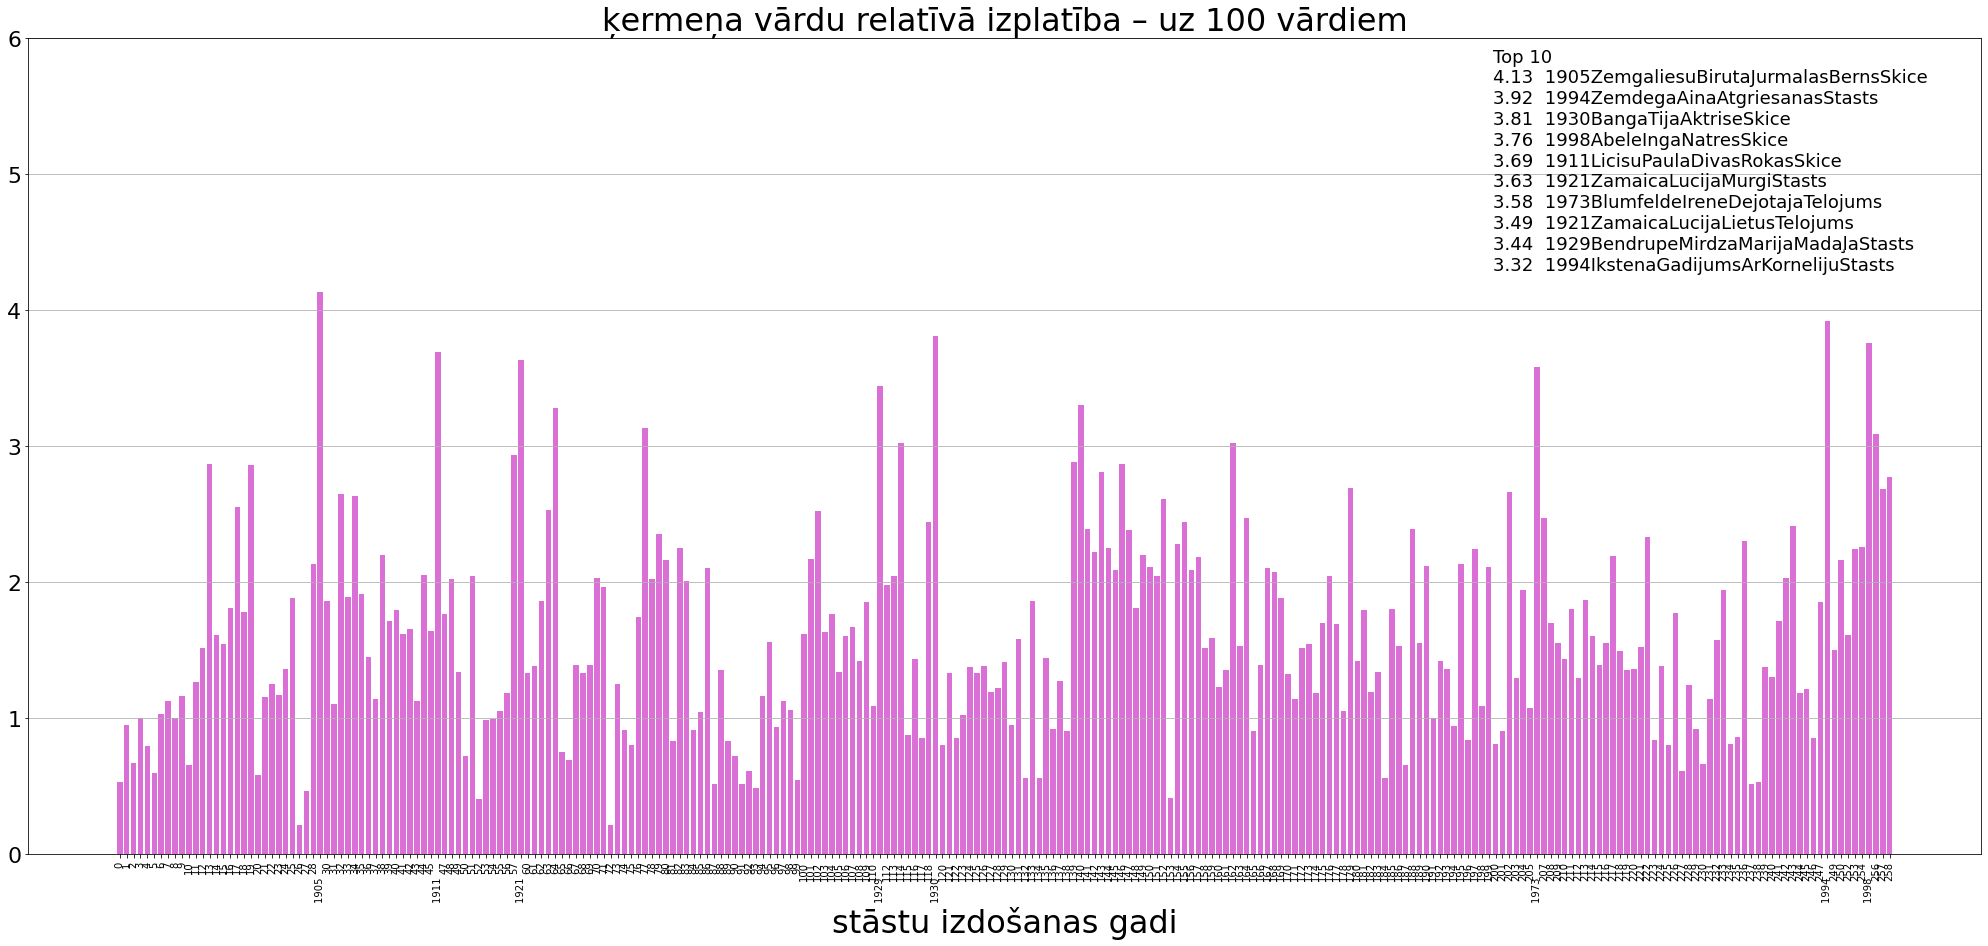

In [18]:
four_kv_types = ['VISS_KERMENIS', 'KERMENA_DALAS', 'GALVA_UN_DALAS',
       'CITI_VARDI']

kv_types_relative = kv_types_relative.sort_values("faila_nosaukums")

# Create main figure
f = plt.figure(figsize=(35, 15))


# x_values
fnames_list = list(kv_types_relative['faila_nosaukums'])
x_list = fnames_list
 
# calculation for y_values
relatives_list = list(kv_types_relative['kv_procentos'])
sorted_y = sorted(relatives_list, reverse=True)
fifth_value = sorted_y[9]  

new_x_list = []
text_box = []
for idx, (x_val, y_val) in enumerate(zip(fnames_list, relatives_list)):
    if y_val < fifth_value:
        new_x_list.append(str(idx))
    else:
        new_x_list.append(x_val[:4] + "     ")
        text_box.append([ round(y_val, 2), x_val])

text_box = sorted(text_box, reverse=True)
text_box = [ f"{el[0]}  {el[1]}" for el in text_box]
text_box.insert(0, "Top 10")
text_string = "\n".join(text_box)
  
x = new_x_list
y = relatives_list
label = lemma
    

# # add as a subplot to the figure
ax1 = f.add_subplot(111)

ax1.grid(axis='x')
ax1.grid()
ax1.bar(x,y, label=label, color="orchid")
#     ax1.set_ylabel('lietojumu skaits uz 100 vārdiem', fontsize=18)
ax1.set_xlabel('stāstu izdošanas gadi', fontsize=32)
ax1.tick_params(axis='y', which='major', labelsize=22)
ax1.set_title(f'ķermeņa vārdu relatīvā izplatība – uz 100 vārdiem', fontsize=32)
# ax1.legend([lemma], fontsize=14, loc='upper left')
ax1.text(0.75, 0.85, text_string, fontsize=18, horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes)
ax1.set_ylim(0, 6.0)
plt.xticks(rotation=90)

# f.suptitle('Top10 biežākie ķermeņa vārdi – relatīvā izplatība KATRĀ TEKSTĀ', fontsize=24)
# f.subplots_adjust(hspace=0.6)

### IZKOMENTĒTS, lai nenotiek pārrakstīšana pa virsu failam
# pp = PdfPages('_76_VISI_kermena_vardi_pa_tekstiem.pdf')
# plt.savefig(pp, format='pdf')
# pp.close()

plt.show()

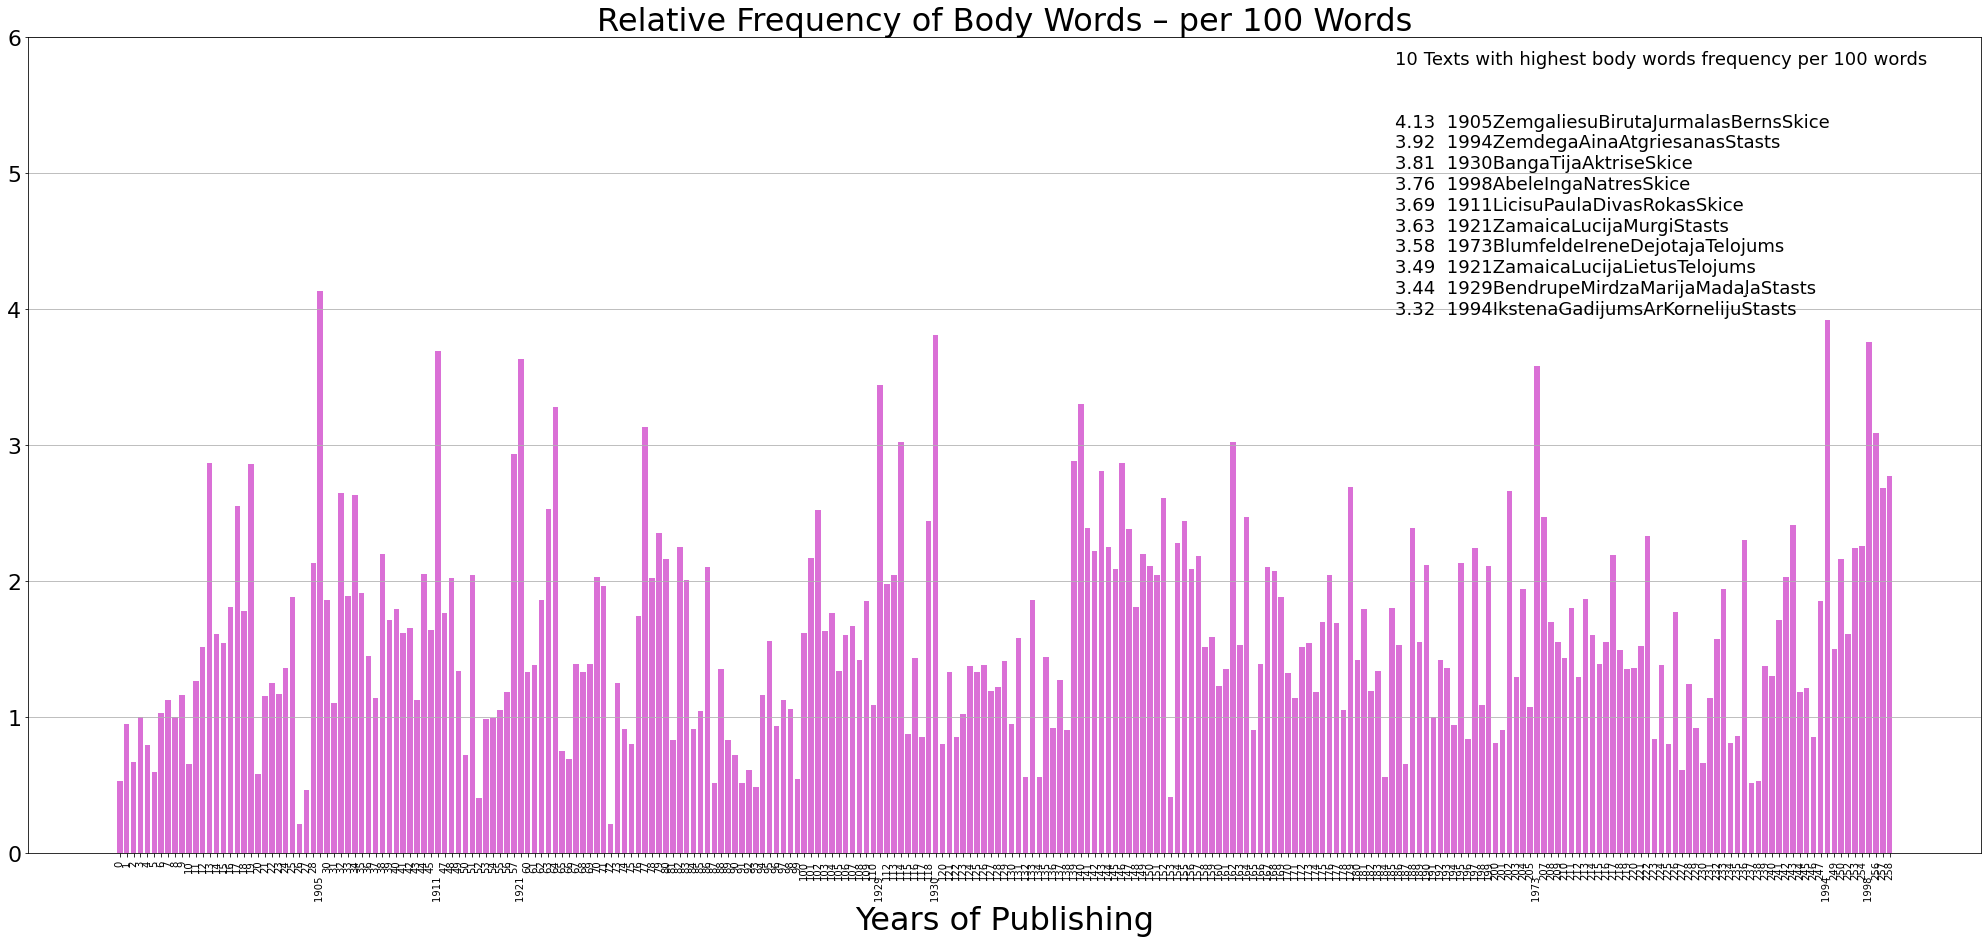

In [22]:
# in ENGLISH
four_kv_types = ['VISS_KERMENIS', 'KERMENA_DALAS', 'GALVA_UN_DALAS',
       'CITI_VARDI']

kv_types_relative = kv_types_relative.sort_values("faila_nosaukums")

# Create main figure
f = plt.figure(figsize=(35, 15))


# x_values
fnames_list = list(kv_types_relative['faila_nosaukums'])
x_list = fnames_list
 
# calculation for y_values
relatives_list = list(kv_types_relative['kv_procentos'])
sorted_y = sorted(relatives_list, reverse=True)
fifth_value = sorted_y[9]  

new_x_list = []
text_box = []
for idx, (x_val, y_val) in enumerate(zip(fnames_list, relatives_list)):
    if y_val < fifth_value:
        new_x_list.append(str(idx))
    else:
        new_x_list.append(x_val[:4] + "     ")
        text_box.append([ round(y_val, 2), x_val])

text_box = sorted(text_box, reverse=True)
text_box = [ f"{el[0]}  {el[1]}" for el in text_box]
text_box.insert(0, "10 Texts with highest body words frequency per 100 words\n\n")
text_string = "\n".join(text_box)
  
x = new_x_list
y = relatives_list
label = lemma
    

# # add as a subplot to the figure
ax1 = f.add_subplot(111)

ax1.grid(axis='x')
ax1.grid()
ax1.bar(x,y, label=label, color="orchid")
#     ax1.set_ylabel('lietojumu skaits uz 100 vārdiem', fontsize=18)
ax1.set_xlabel('Years of Publishing', fontsize=32)
ax1.tick_params(axis='y', which='major', labelsize=22)
ax1.set_title(f'Relative Frequency of Body Words – per 100 Words', fontsize=32)
# ax1.legend([lemma], fontsize=14, loc='upper left')
ax1.text(0.70, 0.82, text_string, fontsize=18, horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes)
ax1.set_ylim(0, 6.0)
plt.xticks(rotation=90)

# f.suptitle('Top10 biežākie ķermeņa vārdi – relatīvā izplatība KATRĀ TEKSTĀ', fontsize=24)
# f.subplots_adjust(hspace=0.6)

### IZKOMENTĒTS, lai nenotiek pārrakstīšana pa virsu failam
# pp = PdfPages('_76_VISI_kermena_vardi_pa_tekstiem.pdf')
# plt.savefig(pp, format='pdf')
# pp.close()

plt.show()

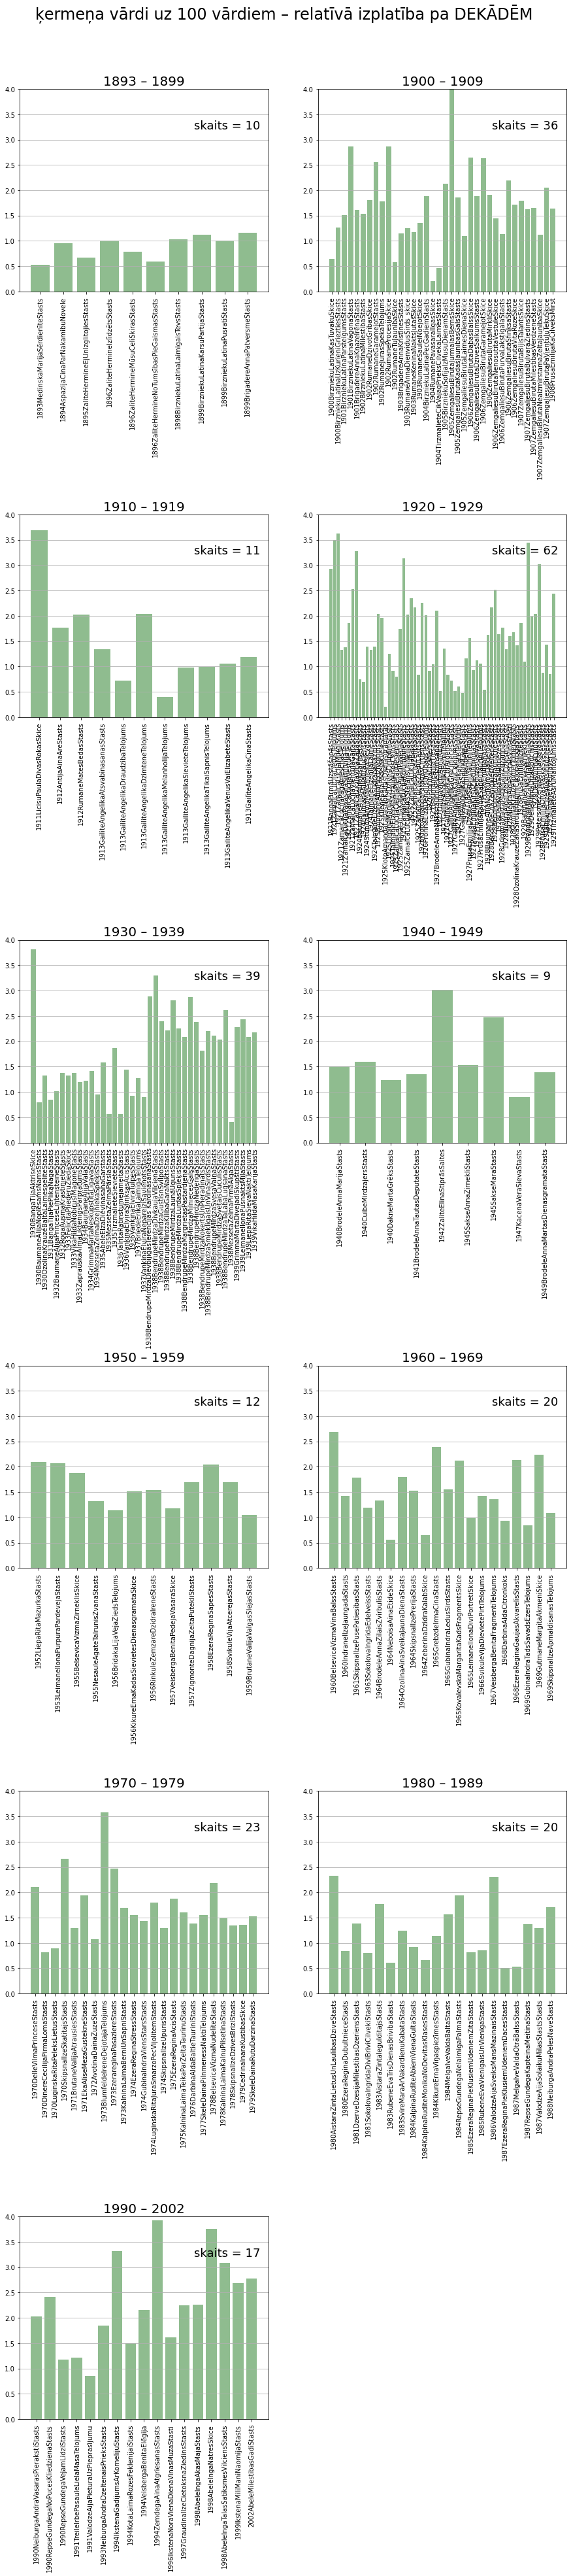

In [20]:

kv_types_relative["gads"] = kv_types_relative["faila_nosaukums"].str.slice(0,4)

# Subplots are organized in a Rows x Cols Grid  # Tot and Cols are known
Tot = 12
Cols = 2
Rows = Tot // Cols   # Compute num of full Rows required
Rows += Tot % Cols   # Add remainder to Rows num

# Create a Position index
Position = range(1,Tot + 1)

# Create main figure
f = plt.figure(figsize=(15, 60))

for k, decade in enumerate(decades_mapping.values()):
#     print(decade)
    lowest = int(decade.split(" ")[0])
    highest = int(decade.split(" ")[2])
    temp_df = kv_types_relative.loc[(kv_types_relative["gads"].astype(int) >= lowest) 
                                    & (kv_types_relative["gads"].astype(int) <= highest)]

    x = temp_df["faila_nosaukums"].tolist()
    y = temp_df["kv_procentos"].tolist()

    ax1 = f.add_subplot(Rows,Cols,Position[k])  # add every single subplot to the figure with a for loop

    ax1.grid(axis='y')
    bars = ax1.bar(x,y, label=label, color="darkseagreen")     # assign your bars to a variable
    ax1.text(0.7, 0.82, f"skaits = {temp_df.shape[0]}", fontsize=18, horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes)
#     ax1.set_ylabel('ķermeņa vārdi uz 100 vārdiem', fontsize=16)
    ax1.set_title(f'{decade}', fontsize=20)
    ax1.set_ylim(0, 4.00)
    plt.xticks(rotation=90)

# f.suptitle('Top10 biežākie ķermeņa vārdi – relatīvā izplatība pa DEKĀDĒM', fontsize=24)
f.suptitle('ķermeņa vārdi uz 100 vārdiem – relatīvā izplatība pa DEKĀDĒM', fontsize=24)

f.subplots_adjust(hspace=1.1)
f.subplots_adjust(top=0.95)


### IZKOMENTĒTS, lai nenotiek pārrakstīšana pa virsu failam
# pp = PdfPages('_74_VISI_kermena_vardi_pa_DEKADEM.pdf')
# plt.savefig(pp, format='pdf')
# pp.close()

plt.show()

# Datu analīze – VISI ķermeņa vārdi pa DEKĀDĒM
Galvenais secinājums – nevienmērīgais tekstu daudzums dažādās dekādēs, jo īpaši relatīvi mazais tekstu daudzums dažās dekādēs (1893—1999, 1910–1919, 1940–1949, 1950–1959, 1990—2002) liedz izdarīt drošus salīdzinājumus.

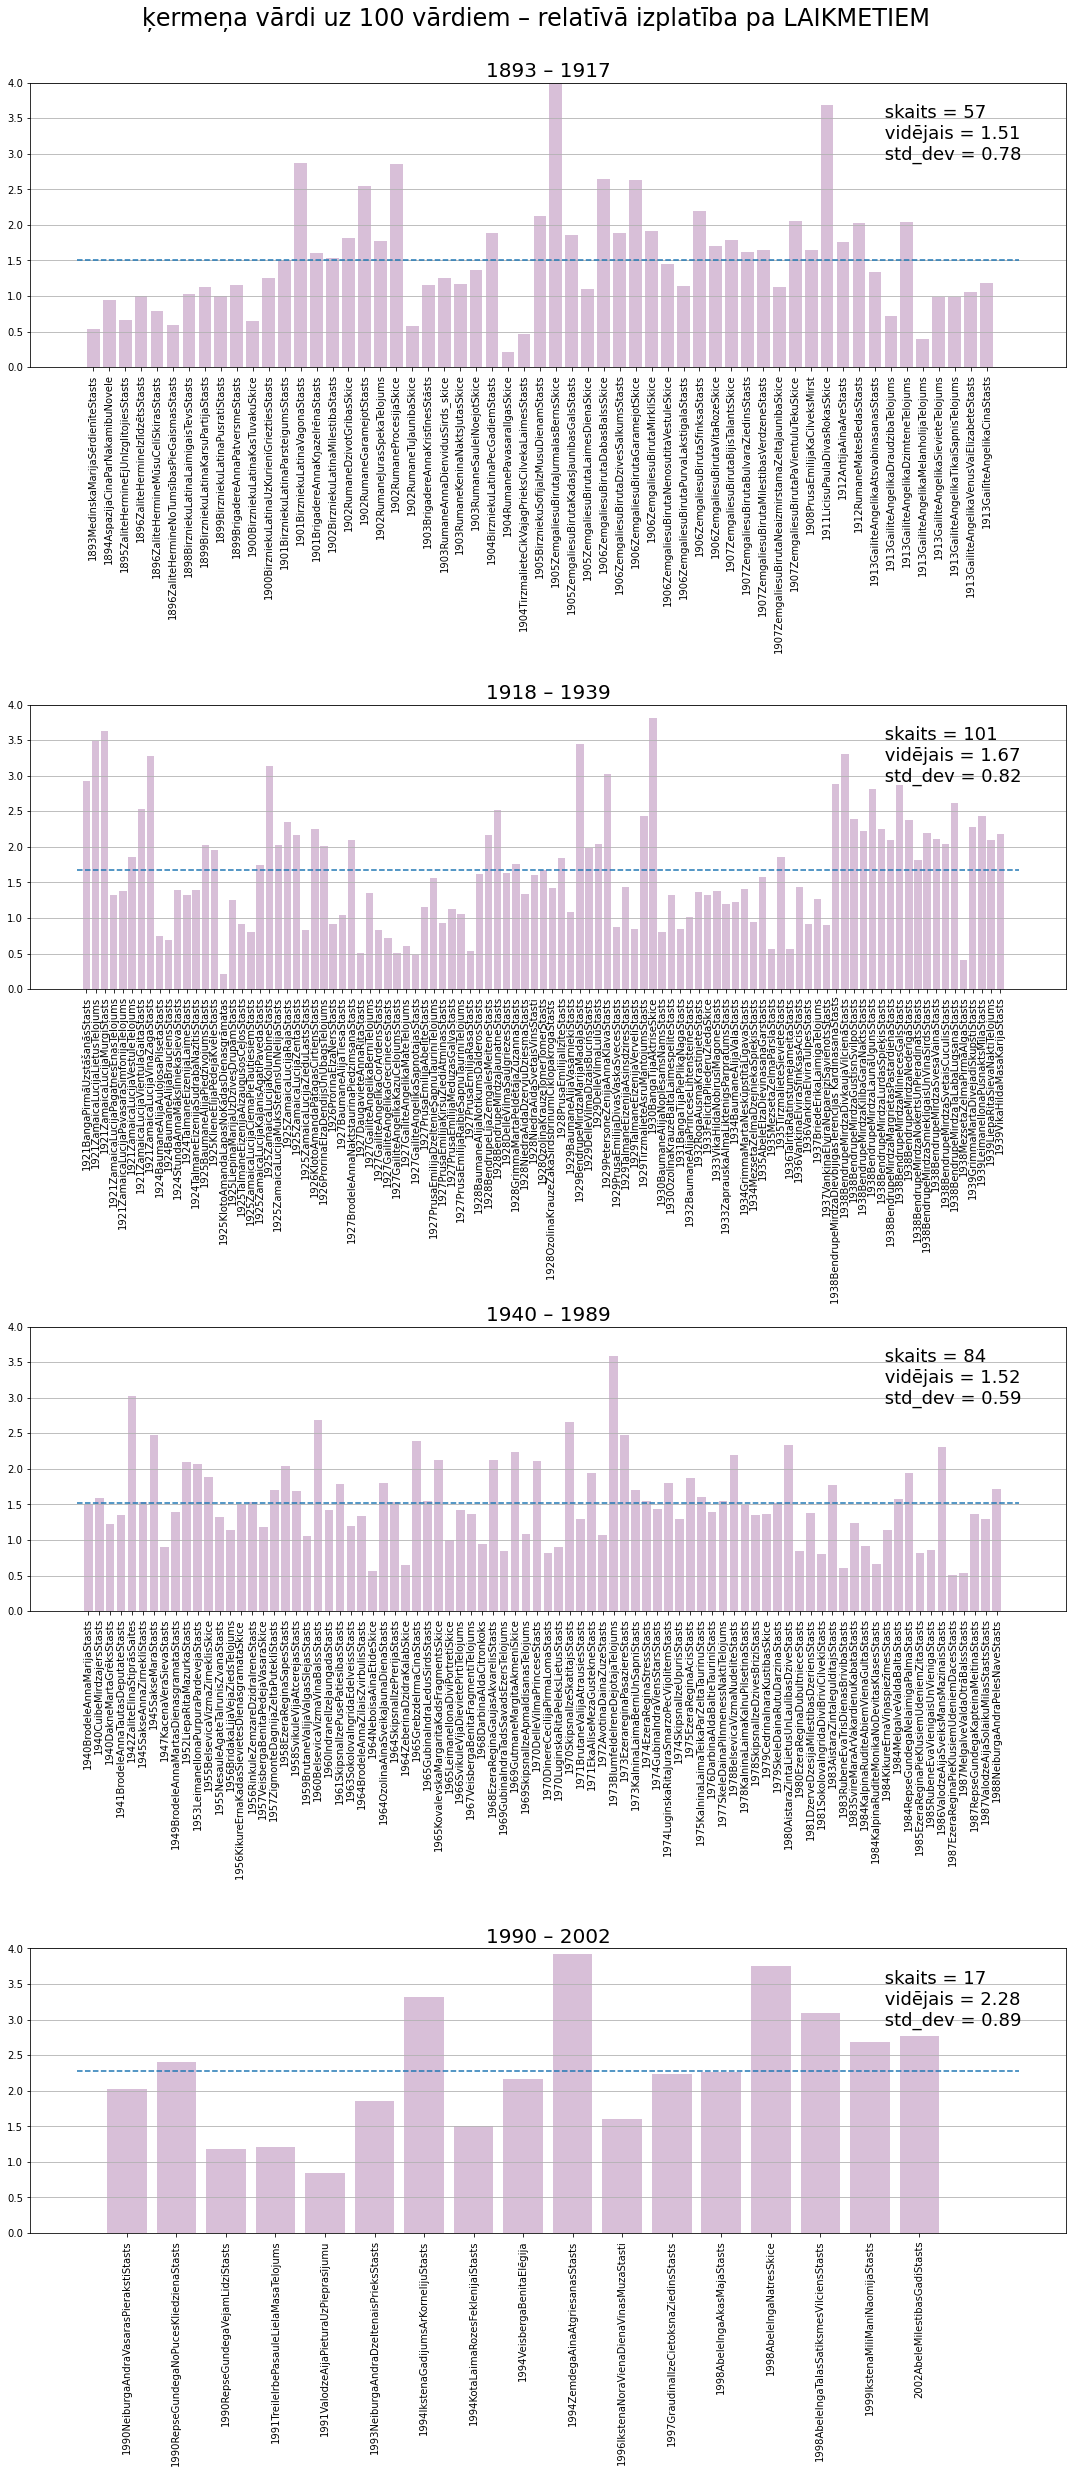

In [21]:
hist_per_mappings = {
    0: "1893 – 1917",
    1: "1918 – 1939",
    2: "1940 – 1989",
    3: "1990 – 2002",
}

kv_types_relative["gads"] = kv_types_relative["faila_nosaukums"].str.slice(0,4)

# Subplots are organized in a Rows x Cols Grid  # Tot and Cols are known
Tot = 4
Cols = 1
Rows = Tot // Cols   # Compute num of full Rows required
Rows += Tot % Cols   # Add remainder to Rows num

# Create a Position index
Position = range(1,Tot + 1)

# Create main figure
f = plt.figure(figsize=(15, 35))

for k, hist_per in enumerate(hist_per_mappings.values()):
#     print(decade)
    lowest = int(hist_per.split(" ")[0])
    highest = int(hist_per.split(" ")[2])
    temp_df = kv_types_relative.loc[(kv_types_relative["gads"].astype(int) >= lowest) 
                                    & (kv_types_relative["gads"].astype(int) <= highest)]

    x = temp_df["faila_nosaukums"].tolist()
    y = temp_df["kv_procentos"].tolist()
    
    skaits = temp_df.shape[0]
    average = sum(temp_df["kv_procentos"].tolist()) / temp_df.shape[0]
    average =  round(average, 2)
    std_dev = statistics.stdev(y)
    std_dev = round(std_dev, 2)
    linelength = temp_df.shape[0]
    text_string = f" skaits = {skaits} \n vidējais = {average} \n std_dev = {std_dev}"
    
    ax1 = f.add_subplot(Rows,Cols,Position[k])  # add every single subplot to the figure with a for loop

    ax1.grid(axis='y')
    ax1.plot((-1, linelength+1), (average, average), '--')
    bars = ax1.bar(x,y, label=label, color="thistle")     # assign your bars to a variable
    ax1.text(0.82, 0.82, text_string, fontsize=18, horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes)
#     ax1.set_ylabel('ķermeņa vārdi uz 100 vārdiem', fontsize=16)
    ax1.set_title(f'{hist_per}', fontsize=20)
    ax1.set_ylim(0, 4.00)
    plt.xticks(rotation=90)

# f.suptitle('Top10 biežākie ķermeņa vārdi – relatīvā izplatība pa DEKĀDĒM', fontsize=24)
f.suptitle('ķermeņa vārdi uz 100 vārdiem – relatīvā izplatība pa LAIKMETIEM', fontsize=24)

f.subplots_adjust(hspace=1.5)

f.tight_layout()
f.subplots_adjust(top=0.95)

### IZKOMENTĒTS, lai nenotiek pārrakstīšana pa virsu failam
# pp = PdfPages('_75_VISI_kermena_vardi_pa_LAIKMETIEM.pdf')
# plt.savefig(pp, format='pdf')
# pp.close()

plt.show()

# Datu analīze – VISI ķermeņa vārdi pa LAIKMETIEM
Vidējās vērtības ir salīdzinoši tuvas pirmajiem trim periodiem – 1.51, 1.67, 1.52, bet ievērojami augstāka pēdējam periodam 2.28. Pēdējam periodam (1990–2002) gan ir ievērojami mazāks izlases kopums (17), kas iespējams ietekmē rezultātu.

Skatoties arī uz standarta novirzi, kas ir salīdzinoši liela visos periodos, gan var secināt, ka vidējās vērtības zināmā mērā ir atsevišķu tekstu nopelns, kamēr ķermeņa vārdu mediānas izplatība ir zemāka.

Tāpat, analizējot periodu 1940–1989, jāpatur prātā, ka tas sastāv no padomju Latvijā un trimdā publicētajiem tekstiem, kas varētu uzrādīt atšķirīgas tendences. (Raugoties gan atpakaļ uz iepriekšējām Top5 tabulām, šķiet, trimdas teksti neizcēlās ļoti reljefi starp biežākajiem.)



